<a href="https://colab.research.google.com/github/banrovegrie/Nostradamus/blob/main/src/Nostradamus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import snowflake.connector
except:
    !pip install snowflake-connector-python
    import snowflake.connector

from pprint import pprint
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import files
import requests

try:
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf

/usr/local/lib/python3.7/dist-packages/snowflake/connector/options.py:97: UserWarning: You have an incompatible version of 'pyarrow' installed (3.0.0), please install a version that adheres to: 'pyarrow<5.1.0,>=5.0.0; extra == "pandas"'
  _expected_pyarrow_version,


In [2]:
#create connection
conn=snowflake.connector.connect(
    user='ZSHAN0',
    password='Zee@snowflack0',
    account='pg84506.ap-south-1.aws',
    database='US_STOCKS_DAILY',
)

In [3]:
def showTables(curs):
  curs.execute("SHOW TABLES")

  tables = [x[1] for x in curs.fetchall()]
  return tables

In [4]:
curs=conn.cursor()
curs.execute("SHOW TABLES")
tables = showTables(curs)
tables

['COMPANY_PROFILE', 'STOCK_HISTORY', 'SYMBOLS']

In [5]:
columnNames = {
    'COMPANY_PROFILE': [], 
    'STOCK_HISTORY': [], 
    'SYMBOLS': [], 
}

In [6]:
curs.execute("DESCRIBE SYMBOLS")
res = curs.fetchall()
[x[0] for x in res]

['ID', 'SYMBOL', 'NAME', 'EXCHANGE']

# Getting data

In [7]:
def getColumns(curs, tableName):
    curs.execute(f"DESCRIBE {tableName}")
    return [x[0] for x in curs.fetchall()]

In [8]:
for table in tables:
    print(getColumns(curs, table))

['ID', 'SYMBOL', 'PRICE', 'BETA', 'VOLAVG', 'MKTCAP', 'LASTDIV', 'RANGE', 'CHANGES', 'COMPANYNAME', 'EXCHANGE', 'INDUSTRY', 'WEBSITE', 'DESCRIPTION', 'CEO', 'SECTOR', 'DCFDIFF', 'DCF']
['ID', 'SYMBOL', 'DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'ADJCLOSE']
['ID', 'SYMBOL', 'NAME', 'EXCHANGE']


In [9]:
def getData(curs, tableName, numRows=0):
    if numRows == 0:
        curs.execute(f"SELECT * FROM {tableName}")
    else:
        curs.execute(f"SELECT * FROM {tableName} LIMIT {numRows}")
    rows = curs.fetchall()
    columnNames = getColumns(curs, tableName)
    df = pd.DataFrame(rows, columns=columnNames)
    return df

In [10]:
symbols = getData(curs, 'SYMBOLS')
symbols

,ID,SYMBOL,NAME,EXCHANGE
0,28674,SPY,SPDR S&P 500,NYSE Arca
1,28675,CMCSA,Comcast Corp,Nasdaq Global Select
2,28676,KMI,Kinder Morgan Inc,New York Stock Exchange
3,28677,INTC,Intel Corp,Nasdaq Global Select
4,28678,MU,Micron Technology Inc,Nasdaq Global Select
...,...,...,...,...
10908,43096,GOED,1847 Goedeker Inc.,NYSE American
10909,43098,RXT,"Rackspace Technology, Inc.",NasdaqGS
10910,43102,TCEHY,Tencent Holdings Limited,Other OTC
10911,43105,PROSY,Prosus N.V.,Other OTC


In [11]:
def getCompanySymbols():
    return list(set(symbols['SYMBOL'].tolist()))

In [13]:
def getDataFromSymbols(curs, symbol, numRows=0):
    if numRows == 0:
        curs.execute(f"SELECT * FROM STOCK_HISTORY WHERE SYMBOL='{symbol}'")
    else:
        curs.execute(f"SELECT * FROM STOCK_HISTORY WHERE SYMBOL='{symbol}' LIMIT {numRows}")
    rows = curs.fetchall()
    columnNames = getColumns(curs, "STOCK_HISTORY")
    df = pd.DataFrame(rows, columns=columnNames)
    return df

In [14]:
aapl = getDataFromSymbols(curs, 'AAPL')
len(aapl)

10278

In [15]:
aapl.sort_values(by=["DATE"], inplace = True)


In [16]:
# aapl.to_csv(r'aapl.csv', index = False, header = True)
# files.download('aapl.csv') 

In [17]:
def saveData(curs, symbolList):
    for company in symbolList:
        df = getDataFromSymbols(curs, company)
        df.sort_values(by=["DATE"], inplace = True)
        df.to_csv(f'{company}.csv', index = False, header = True)
        files.download(f'{company}.csv') 

In [18]:
# saveData(curs, 
#          [
#           "ADM", "BAYRY", "BG", "SMG"
#           "AAPL", "BP", "CVX", 
#           "XOM", "EPD", "COP", "EOG", "NRG", "XEL",  # energy companies
#           "GNRC", "PPSI", "VST" # electronics
#          ]
#          )

# Environment Data

In [19]:
curs.execute("USE ENV")

In [20]:
tables = showTables(curs)
tables

['DATASETS', 'DATA_ATLAS']

In [21]:
datasets = getData(curs, "DATASETS")
data_atlas = getData(curs, "DATA_ATLAS")

In [22]:
data_atlas.head()

,Dataset,Path,Country,Country ISO Code,Topic,Subtopic,Indicator,Description,Source,Uri,Year,Month,Unit,Date,Value
0,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1970,1,Mton CO2,1970-01-01,19.43696
1,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1971,1,Mton CO2,1971-01-01,25.40343
2,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1972,1,Mton CO2,1972-01-01,27.71823
3,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1973,1,Mton CO2,1973-01-01,35.80548
4,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1974,1,Mton CO2,1974-01-01,35.97032


# Cleaning Data

`location=AE;indicator=KN.F1;type=All;Frequency=A`

To split the values into different columns

In [23]:
def splitPath(string, originalAttr):
    string = string.lower()
    l = string.split(';')
    for x in l:
        attr, val = x.split('=')
        if attr == originalAttr:
            return val
    return None

In [24]:
attributesList = []
def func(string):
    l = string.split(';')
    for x in l:
        attr, val = x.split('=')
        attributesList.append(attr)

data_atlas.apply(lambda x: func(x['Path']), axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
339447    None
339448    None
339449    None
339450    None
339451    None
Length: 339452, dtype: object

In [25]:
data_atlas['location'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'location'), axis=1)
data_atlas['indicator'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'indicator'), axis=1)
data_atlas['type'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'type'), axis=1)
data_atlas['frequency'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'frequency'), axis=1)
data_atlas['series'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'series'), axis=1)
data_atlas['variable'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'variable'), axis=1)

# Removing Unnecessary columns

In [26]:
data_atlas.drop(['Path', 'Country', 'Dataset', 'Source', 'Uri', 'Year', 'Month'], axis=1, inplace=True)

In [27]:
data_atlas.head()

,Country ISO Code,Topic,Subtopic,Indicator,Description,Unit,Date,Value,location,indicator,type,frequency,series,variable
0,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1970-01-01,19.43696,ae,kn.f1,all,a,None,None
1,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1971-01-01,25.40343,ae,kn.f1,all,a,None,None
2,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1972-01-01,27.71823,ae,kn.f1,all,a,None,None
3,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1973-01-01,35.80548,ae,kn.f1,all,a,None,None
4,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1974-01-01,35.97032,ae,kn.f1,all,a,None,None


In [28]:
curs.execute('select DISTINCT "Indicator" from DATA_ATLAS')
indicators = list(set([x[0] for x in curs.fetchall()]))

In [29]:
def env_data(country, indicator):
    data_val = data_atlas[(data_atlas['Indicator'] == indicator) & (data_atlas['Country ISO Code'] == country)]
    data_val['Year'] = data_val.apply(lambda x: x["Date"].year, axis=1)
    return data_val[['Year', 'Value']]

# Getting data about the companies sustainibility

In [30]:
def yearlyData(attribute, companyName):
    df = yf.download(tickers=companyName, period='max', interval='3mo', threads=True)
    if attribute == "All":
        for attr in ["Open", "Volume", "Close"]:
            df = df[df[attr].notna()]
    else:
        df = df[df[attribute].notna()]
    df['Year'] = df.apply(lambda x: x.name.year, axis=1)
    df = df.groupby(['Year']).mean()
    df['Year'] = df.index
    df.reset_index(drop=True, inplace=True)
    return df


In [31]:
def mergeOnYear(attribute, country, company, indicator):
    yearly = yearlyData(attribute, company)
    x = yearly[[attribute, 'Year']]
    y = env_data(country, indicator)
    xy = pd.merge(x, y, on='Year', how='inner') 
    return xy

In [32]:
def correlation(attr, country, company, indicator):
    df_cov = mergeOnYear(attr, country, company, indicator)
    return df_cov[attr].corr(df_cov['Value'])

In [33]:
def plot_correlation(attr, country, company, indicator):
    df_cov = mergeOnYear(attr, country, company, indicator)
    print(df_cov.head())
    print()
    print("Correlation = ", df_cov[attr].corr(df_cov['Value']))
    print()
    plt.plot(df_cov['Year'], (df_cov[attr] - df_cov[attr].min())/(df_cov[attr].max() - df_cov[attr].min()), label=attr)
    plt.plot(df_cov['Year'], (df_cov['Value'] - df_cov['Value'].min())/(df_cov['Value'].max() - df_cov['Value'].min()), label=indicator)
    plt.legend()

# Correlation between indicators and company prices

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


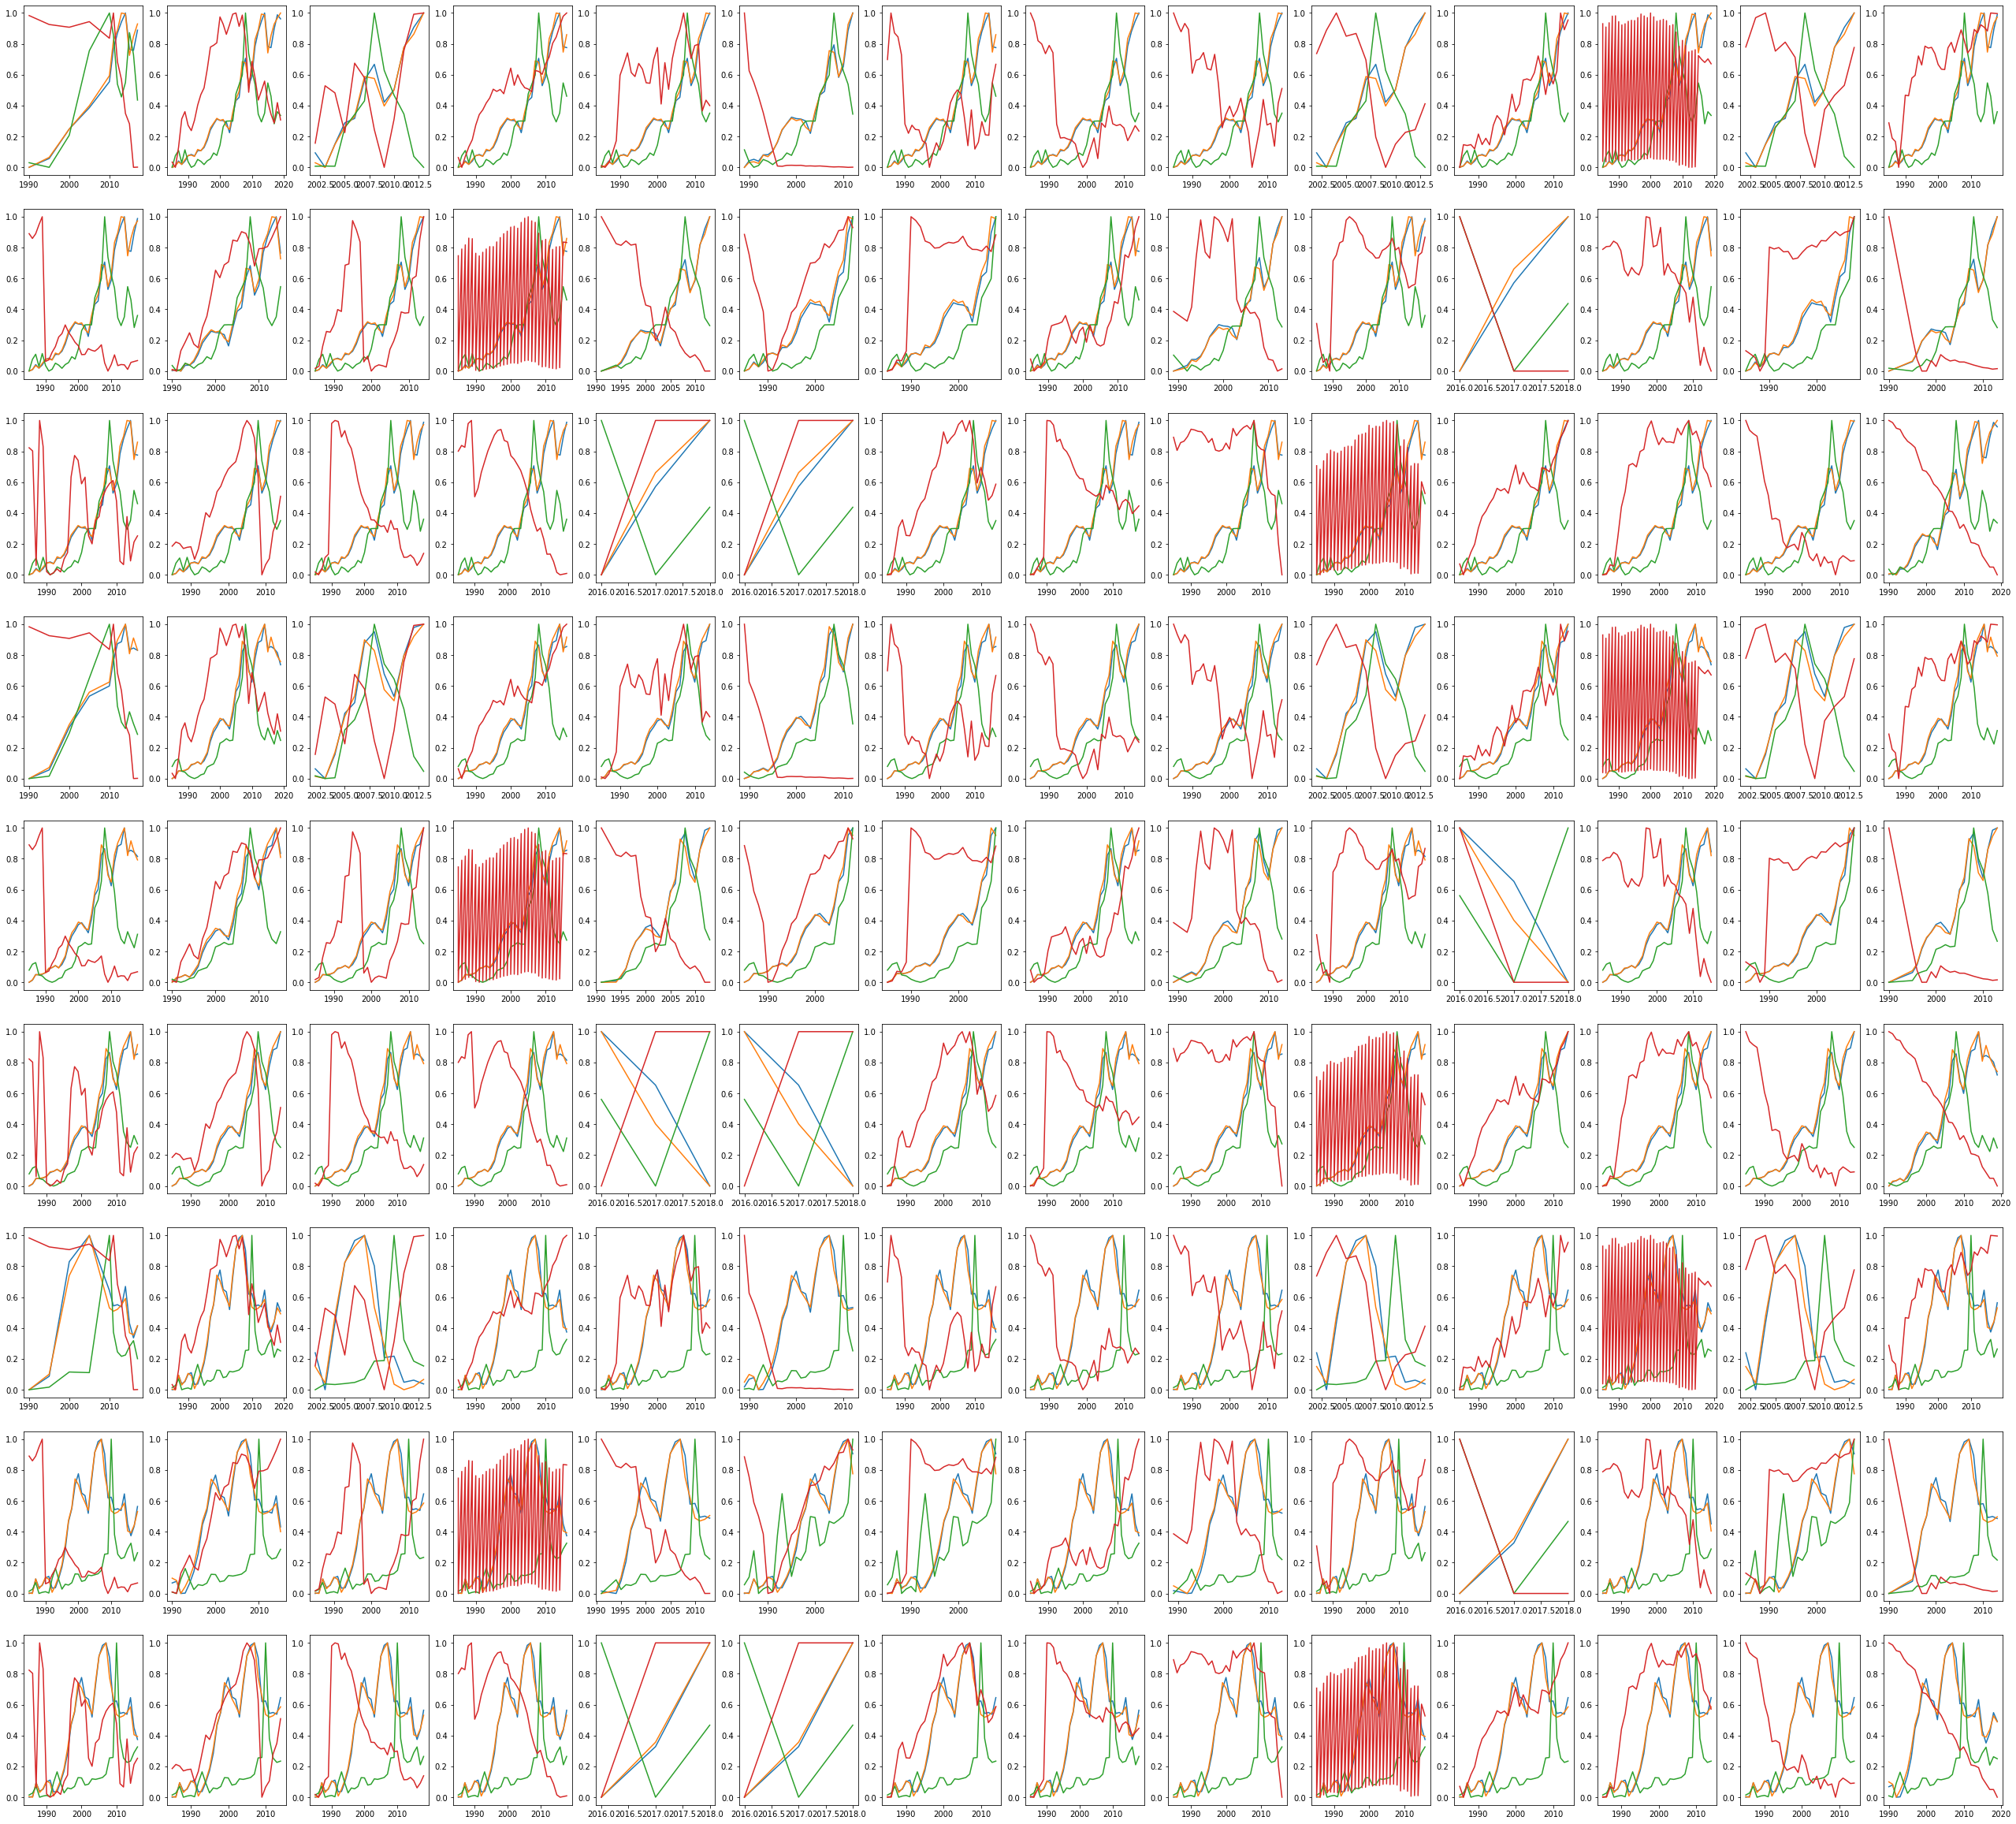

In [34]:
companies = ["CVX", "XOM", "BP", "AAPL", "SPY"]
count = 0
corList = []
plt.figure(figsize=(45, 42))
for company in companies:
    try:
        yearly = yearlyData("All", company)
        x = yearly
    except:
        counter += len(indicators)
        continue
    for indicator in indicators:
        try:
            y = env_data('US', indicator)
            df_cov = pd.merge(x, y, on='Year', how='inner') 
            correlOpen = df_cov['Open'].corr(df_cov['Value'])
            correlClose = df_cov['Close'].corr(df_cov['Value'])
            correlVolume = df_cov['Volume'].corr(df_cov['Value'])
            if np.isnan(correlOpen) or np.isnan(correlClose) or np.isnan(correlVolume):
                continue
            count += 1
            corList.append([indicator, company, correlOpen, correlClose, correlVolume])
            plt.subplot(9, 14, count)
            plt.plot(df_cov['Year'], (df_cov['Open'] - df_cov['Open'].min())/(df_cov['Open'].max() - df_cov['Open'].min()))
            plt.plot(df_cov['Year'], (df_cov['Close'] - df_cov['Close'].min())/(df_cov['Close'].max() - df_cov['Close'].min()))
            plt.plot(df_cov['Year'], (df_cov['Volume'] - df_cov['Volume'].min())/(df_cov['Volume'].max() - df_cov['Volume'].min()))
            plt.plot(df_cov['Year'], (df_cov['Value'] - df_cov['Value'].min())/(df_cov['Value'].max() - df_cov['Value'].min()))
            plt.set_title(count)
        except:
            continue

In [35]:
corDf = pd.DataFrame(data=corList, columns=["Indicator", "Company", "Open Correlation", "Close Correlation", "Volume Correlation"])
corDf = corDf[corDf['Open Correlation'].notna()]
corDf = corDf[corDf['Close Correlation'].notna()]
corDf = corDf[corDf['Volume Correlation'].notna()]
corDf = corDf.sort_values(by='Open Correlation', ascending=False)
corDf

,Indicator,Company,Open Correlation,Close Correlation,Volume Correlation
147,CO2 emissions from gaseous fuel consumption (%),AAPL,0.928604,0.930080,-0.029746
159,Terrestrial and marine protected areas,AAPL,0.908637,0.950297,-0.752585
158,Terrestrial protected areas,AAPL,0.908637,0.950297,-0.752585
52,CO2 emissions: transport (%),XOM,0.906557,0.911283,0.570961
10,CO2 emissions: transport (%),CVX,0.906016,0.908090,0.623050
...,...,...,...,...,...
24,Marine protected areas,CVX,-0.904345,-0.943073,0.899678
92,CO2 emissions: residential buildings (%),BP,-0.907994,-0.904199,-0.423270
150,Marine protected areas,AAPL,-0.908637,-0.950297,0.752585
83,CO2 emissions intensity,XOM,-0.946313,-0.940741,-0.563387


# Low correlation

[*********************100%***********************]  1 of 1 completed
        Open  Year         Value
0   6.261719  1985  183038.91199
1   7.464844  1986  177973.31243
2  10.863281  1987  174414.09811
3  10.640625  1988  175257.62944
4  11.007812  1989  172495.69713

Correlation =  0.23892623980403022



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


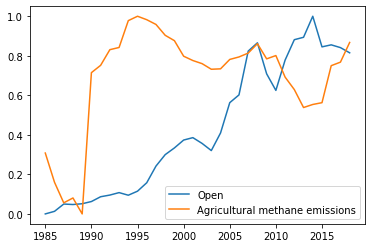

In [49]:
plot_correlation('Open', 'US', 'XOM', 'Agricultural methane emissions')

# Strong correlation
The following is a graph of the stock price of `BP` compared to the CO2 emissions in the surroundings. This can be backed up and can be claimed as causation since `BP` is an oil industry.

But note that we can't judge the correlation as the causation immedietely, as we will see an example of correlation $\neq$ causation.

[*********************100%***********************]  1 of 1 completed
        Open  Year       Value
0  11.382812  1985  4775.39958
1  11.656250  1986  4734.69220
2  16.757812  1987  4892.10505
3  13.593750  1988  5115.29985
4  14.382812  1989  5172.66620

Correlation =  0.8158776413348325



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


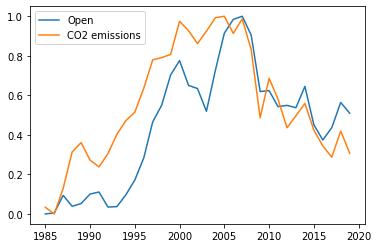

In [36]:
plot_correlation('Open', 'US', 'BP', 'CO2 emissions')

## Correlation $\neq$ Causation 

[*********************100%***********************]  1 of 1 completed
      Close  Year     Value
0  0.110491  1984  19.81955
1  0.086496  1985  19.15795
2  0.205357  1986  18.18400
3  0.378349  1987  18.46471
4  0.346541  1988  18.54754

Correlation =  0.9300802887717905



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


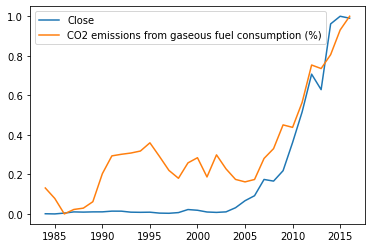

In [37]:
plot_correlation('Close', 'US', 'AAPL', 'CO2 emissions from gaseous fuel consumption (%)')

### Hidden correlations
It is likely that there are hidden correlations due to dependencies of carbon emissions on an industry which also determines whether the prices of companies which own/invest in the same.

This means large companies such as large banks and firms.

[*********************100%***********************]  1 of 1 completed
        Volume  Year     Value
0  507445275.0  2016  26.32620
1  350719875.0  2017  26.32808
2  419315925.0  2018  26.32808

Correlation =  -0.8996779149265138



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


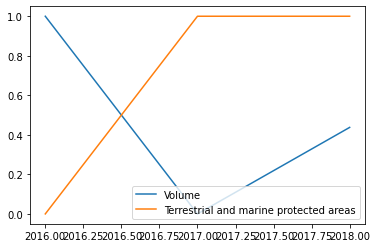

In [38]:
plot_correlation('Volume', 'US', 'CVX', 'Terrestrial and marine protected areas')

[*********************100%***********************]  1 of 1 completed
     Close  Year       Value
0  18.3350  2007  5931.98924
1  12.2200  2008  5742.92717
2  10.3000  2009  5325.07672
3   9.7200  2010  5567.63989
4   9.0975  2011  5438.91893

Correlation =  0.9276561265498262



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


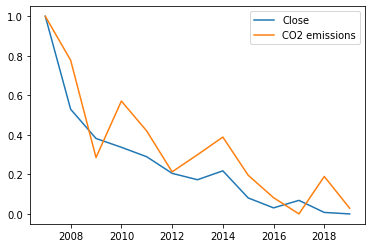

In [39]:
plot_correlation('Close', 'US', 'EOD', 'CO2 emissions')

# Stock market and monthly weather correlation

In [40]:
weather_data = pd.read_csv('https://media.githubusercontent.com/media/banrovegrie/Nostradamus/main/data/weather/weather.csv?token=ANSXAPJHIJFS4MN7YQSFD5LBNRBIS')


In [41]:
weather_data.rename(columns={'AWND': 'Wind', 'PRCP': 'Precipitation', 'SNOW':'Snowfall', "SNWD":"Snowdepth", 'TAVG':'Temp'}, inplace=True)
weather_data = weather_data[~weather_data['Wind'].isnull() & ~weather_data['Temp'].isnull()]
weather_data = weather_data[~weather_data['Snowfall'].isnull() & ~weather_data['Snowdepth'].isnull()]
weather_data = weather_data[~weather_data['Precipitation'].isnull()]
weather_data['Date'] = weather_data['DATE']
weather_data

,STATION,DATE,Wind,Precipitation,Snowfall,Snowdepth,Temp,Date
6665,USW00094789,1998-04-01,4.6,13.5,0.0,0.0,12.2,1998-04-01
6666,USW00094789,1998-04-02,2.9,0.0,0.0,0.0,10.6,1998-04-02
6667,USW00094789,1998-04-03,4.9,0.0,0.0,0.0,11.1,1998-04-03
6668,USW00094789,1998-04-04,6.6,0.0,0.0,0.0,6.7,1998-04-04
6669,USW00094789,1998-04-05,8.0,0.0,0.0,0.0,7.2,1998-04-05
...,...,...,...,...,...,...,...,...
15243,USW00094789,2021-09-25,2.2,0.0,0.0,0.0,19.3,2021-09-25
15244,USW00094789,2021-09-26,6.3,0.0,0.0,0.0,19.8,2021-09-26
15245,USW00094789,2021-09-27,6.3,0.0,0.0,0.0,20.7,2021-09-27
15246,USW00094789,2021-09-28,4.9,2.3,0.0,0.0,20.6,2021-09-28


In [42]:
def toString(timestamp):
    return timestamp.strftime("%Y-%m-%d")

In [43]:
def dailyData(companyName, attribute):
    df = yf.download(tickers=companyName, period='max', interval='1d', threads=True)
    df = df[df[attribute].notna()]
    df['Date'] = df.apply(lambda x: x.name, axis=1)
    df.reset_index(drop=True, inplace=True)
    return df

In [44]:
def weather_correlation_value(weather_data, stock, attribute, weather_param):
    df = dailyData(stock, attribute)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df.apply(lambda f: toString(f['Date']), axis=1)
    x = df[[attribute, 'Date']]

    weather_data['Date'] = pd.to_datetime(weather_data['Date'])
    weather_data['Date'] = weather_data.apply(lambda f: toString(f['Date']), axis=1)
    y = weather_data[[weather_param, 'Date']]
    df_cov = pd.merge(x, y, on='Date', how='inner')
    correlation = df_cov[attribute].corr(df_cov[weather_param])
    return correlation

In [45]:
def weather_correlation(weather_data, stock, attribute, weather_param):
    df = dailyData(stock, attribute)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df.apply(lambda f: toString(f['Date']), axis=1)
    x = df[[attribute, 'Date']]

    weather_data['Date'] = pd.to_datetime(weather_data['Date'])
    weather_data['Date'] = weather_data.apply(lambda f: toString(f['Date']), axis=1)
    y = weather_data[[weather_param, 'Date']]
    df_cov = pd.merge(x, y, on='Date', how='inner')
    correlation = df_cov[attribute].corr(df_cov[weather_param])
    print("Correlation = ", correlation)
    print()
    plt.plot(df_cov['Date'], (df_cov[attribute] - df_cov[attribute].min())/(df_cov[attribute].max() - df_cov[attribute].min()), label=attribute)
    plt.plot(df_cov['Date'], (df_cov[weather_param] - df_cov[weather_param].min())/(df_cov[weather_param].max() - df_cov[weather_param].min()), label=weather_param)
    plt.legend()

[*********************100%***********************]  1 of 1 completed
Correlation =  0.03380256532876184



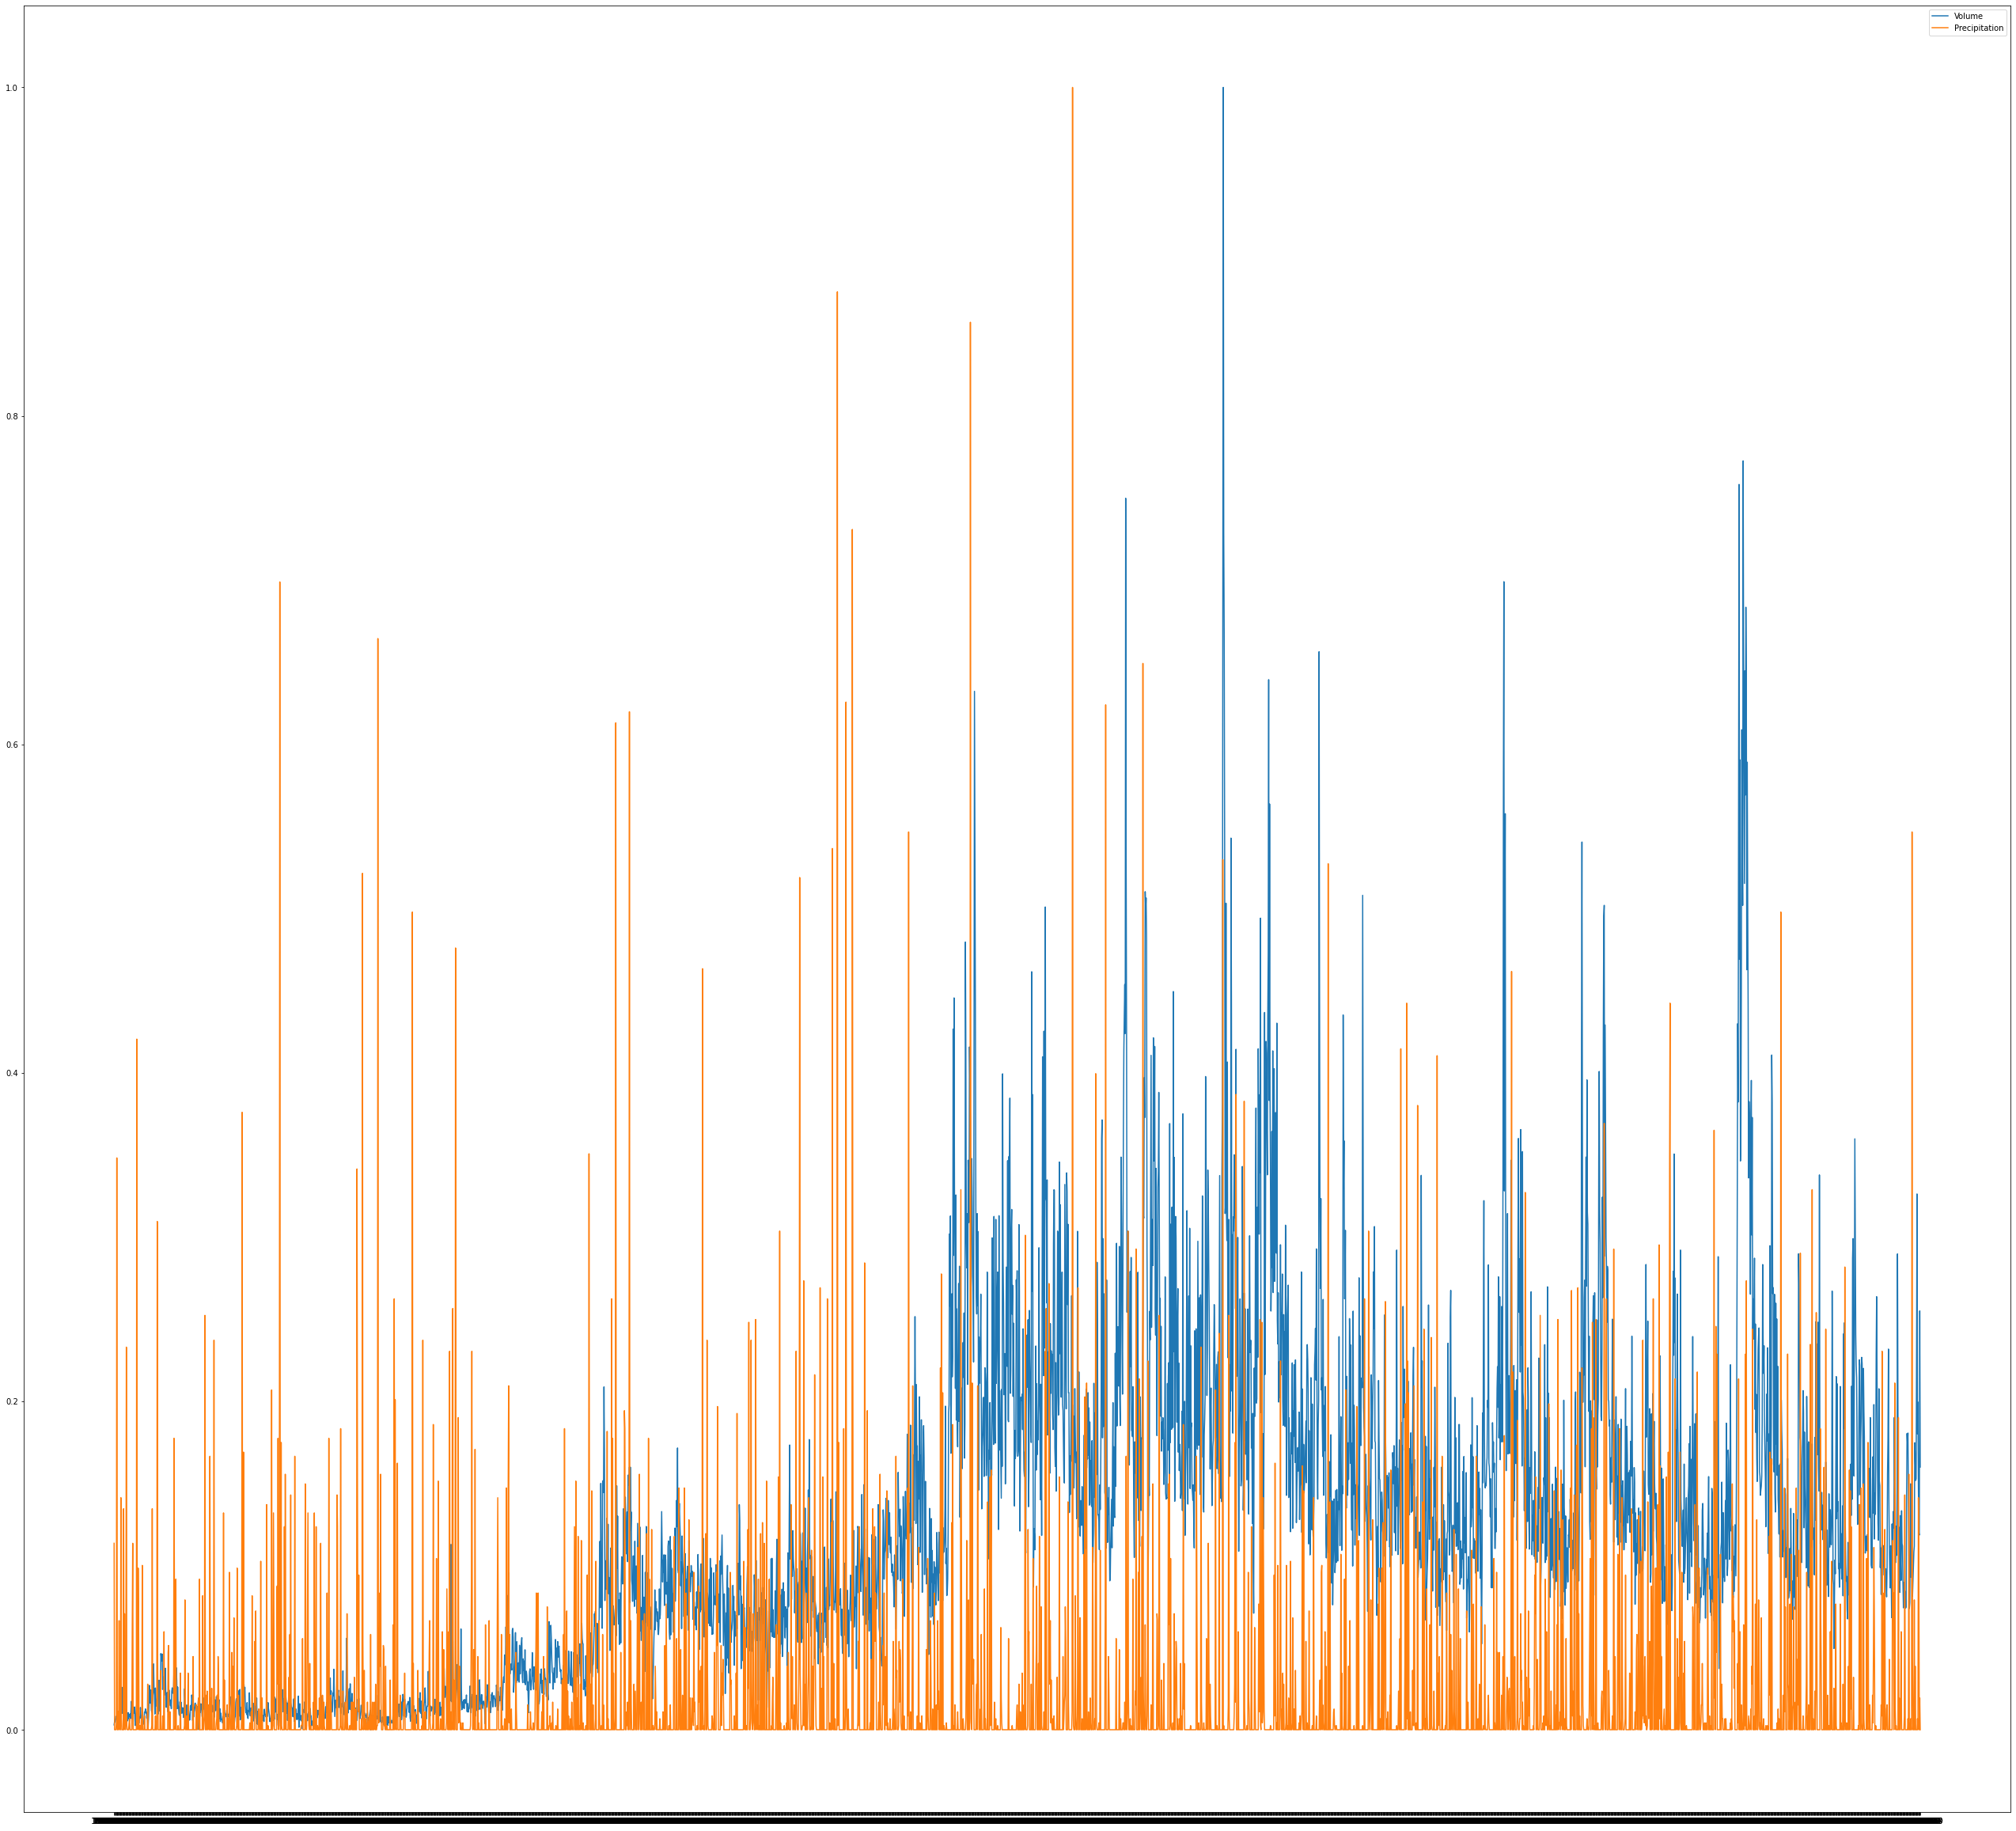

In [46]:
plt.figure(figsize=(45, 42))
weather_correlation(weather_data, 'SPY', 'Volume', 'Precipitation')

In [47]:
attrs = ["Wind", "Precipitation", "Snowfall", "Snowdepth", "Temp"]
rows = []
for company in companies:
    for attr in attrs:
        corr = weather_correlation_value(weather_data, company, 'Open', attr)
        rows.append([company, attr, corr])

rows = pd.DataFrame(rows, columns=["Company", "Attribute", "Correlation"])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [48]:
rows.head()

,Company,Attribute,Correlation
0,CVX,Wind,-0.008124
1,CVX,Precipitation,0.022322
2,CVX,Snowfall,0.016507
3,CVX,Snowdepth,-0.022004
4,CVX,Temp,0.036520
